## An EDA (Exploratory Data Analysis) for ImageNet sketch image classification


### Step 0. Importing libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
import numpy as np
import cv2
from collections import defaultdict
import os

### Step 1. Metadata analysis

In [2]:
# directory/file name settings
traindata_dir = "./data/train"
traindata_info_file = "./data/train.csv"

testdata_dir = "./data/test"
testdata_info_file = "./data/test.csv"

In [3]:
# read the data
train_data = pd.read_csv(traindata_info_file)
test_data = pd.read_csv(testdata_info_file)

In [4]:
# check the train data with df.info() & df.head() & df.describe()
train_data.info(), train_data.head(), train_data.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15021 entries, 0 to 15020
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   class_name  15021 non-null  object
 1   image_path  15021 non-null  object
 2   target      15021 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 352.2+ KB


(None,
   class_name                image_path  target
 0  n01872401  n01872401/sketch_50.JPEG      59
 1  n02417914  n02417914/sketch_11.JPEG     202
 2  n02106166   n02106166/sketch_3.JPEG     138
 3  n04235860   n04235860/sketch_2.JPEG     382
 4  n02056570  n02056570/sketch_40.JPEG      80,
        class_name                image_path        target
 count       15021                     15021  15021.000000
 unique        500                     15021           NaN
 top     n04004767  n01688243/sketch_31.JPEG           NaN
 freq           31                         1           NaN
 mean          NaN                       NaN    249.989082
 std           NaN                       NaN    144.471752
 min           NaN                       NaN      0.000000
 25%           NaN                       NaN    125.000000
 50%           NaN                       NaN    250.000000
 75%           NaN                       NaN    375.000000
 max           NaN                       NaN    499.000

- 학습 데이터셋은 15,021개 스케치 이미지의 class name (str), 경로 (str), 클래스 (int64) 정보를 포함하고 있다.
- 결측치 없음
- 500개의 클래스가 있다. (0 ~ 499)

In [5]:
# check the test data with df.info() & df.head()
test_data.info(), test_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10014 entries, 0 to 10013
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  10014 non-null  object
dtypes: object(1)
memory usage: 78.4+ KB


(None,
   image_path
 0     0.JPEG
 1     1.JPEG
 2     2.JPEG
 3     3.JPEG
 4     4.JPEG)

- 테스트 데이터셋은 10,014개 스케치 이미지의 경로 [str] 정보를 포함하고 있다.
- 결측치 없음

Text(0, 0.5, '# of samples')

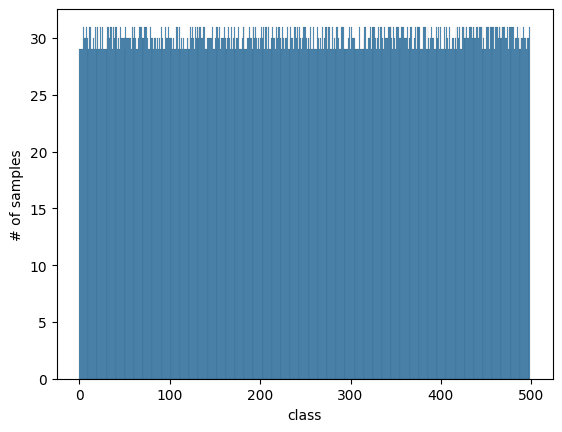

In [23]:
# check the class imbalance
plt.figure()
sns.histplot(train_data['target'], bins=500)
plt.xlabel('class')
plt.ylabel('# of samples')

- 500개의 클래스에 약 30개씩의 이미지가 포함되어 있다.
- 클래스에 따른 불균형 없이 고르게 분포하는 것으로 보임

### Step 2. Image analysis

In [7]:
# file
train_images = glob(traindata_dir + "/*/*")
test_images = glob(testdata_dir + "/*")

In [19]:
# extract image features & save as a DataFrame
image_prop = defaultdict(list)

for i, path in enumerate(train_images):
    try:    # in case of color image
        with Image.open(path) as img:
            # color info
            img = img.convert('RGB')
            img_array = np.array(img)
            mean_red = np.mean(img_array[:, :, 0])
            mean_green = np.mean(img_array[:, :, 1])
            mean_blue = np.mean(img_array[:, :, 2])
            image_prop['mean_red'].append(mean_red)
            image_prop['mean_green'].append(mean_green)
            image_prop['mean_blue'].append(mean_blue)

            # other info
            image_prop['height'].append(img.height)
            image_prop['width'].append(img.width)
            image_prop['mode'].append(img.mode)    # RGB? L? RGBA?
            image_prop['format'].append(img.format)
            image_prop['size'].append(round(os.path.getsize(path) / 1e6, 2))    # volume
        image_prop['image_path'].append(path.split('/')[-2] + "/" + path.split('/')[-1])
    except:   # in case of monochrome image
        with Image.open(path) as img:
            image_prop['height'].append(img.height)
            image_prop['width'].append(img.width)
            image_prop['mode'].append(img.mode)    # RGB? L? RGBA?
            image_prop['format'].append(img.format)
            image_prop['size'].append(round(os.path.getsize(path) / 1e6, 2))    # volume
        image_prop['image_path'].append(path.split('/')[-2] + "/" + path.split('/')[-1])
        image_prop['mean_red'].append(None)
        image_prop['mean_green'].append(None)
        image_prop['mean_blue'].append(None)

image_data = pd.DataFrame(image_prop)
image_data['ratio'] = image_data['height'] / image_data['width']

image_data = image_data.merge(train_data, on='image_path')

Text(0.5, 1.0, 'Image file size distribution')

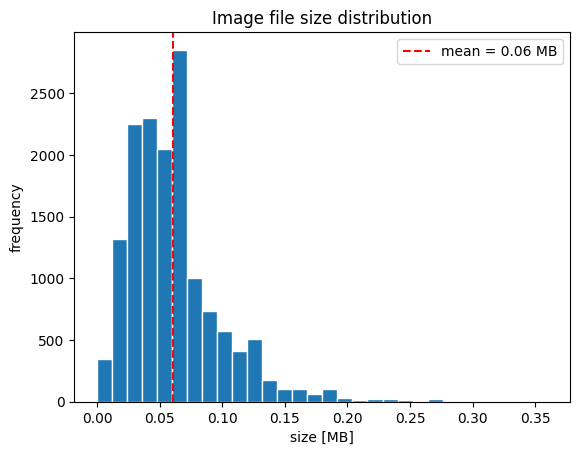

In [32]:
# check the volume
plt.hist(image_data['size'], bins=30, ec='white')
plt.xlabel('size [MB]')
plt.ylabel('frequency')
plt.axvline(np.mean(image_data['size']), ls='--', c='red', label='mean = {} MB'.format(round(np.mean(image_data['size']),2)))
plt.legend()
plt.title('Image file size distribution')

- 평균 0.06 MB 의 작은 용량의 이미지들이 대부분

Text(0.5, 1.0, 'height-width ratio distribution')

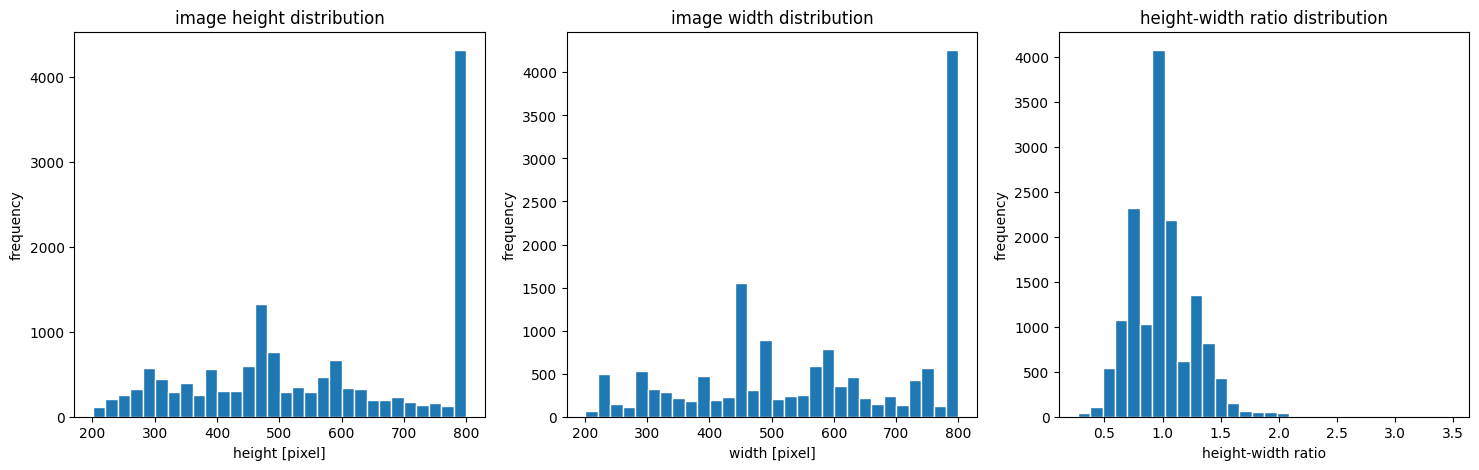

In [37]:
# check the image height, width, ratio
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# subplot 1. height
ax[0].hist(image_data['height'], bins=30, ec='white')
ax[0].set_xlabel('height [pixel]')
ax[0].set_ylabel('frequency')
ax[0].set_title('image height distribution')

# subplot 2. width
ax[1].hist(image_data['width'], bins=30, ec='white')
ax[1].set_xlabel('width [pixel]')
ax[1].set_ylabel('frequency')
ax[1].set_title('image width distribution')

# subplot 3. height/width ratio
ax[2].hist(image_data['ratio'], bins=30, ec='white')
ax[2].set_xlabel('height-width ratio')
ax[2].set_ylabel('frequency')
ax[2].set_title('height-width ratio distribution')

- height, width가 ~800 픽셀인 이미지가 대다수고, 그 절반 정도 크기인 이미지도 많아보임
- 가로-세로 비가 1인 정사각형 이미지 데이터가 많아보이고, 최소값은 0.27, 최대값은 3.48 로 극단적인 비율도 보임

(np.float64(-0.5), np.float64(229.5), np.float64(799.5), np.float64(-0.5))

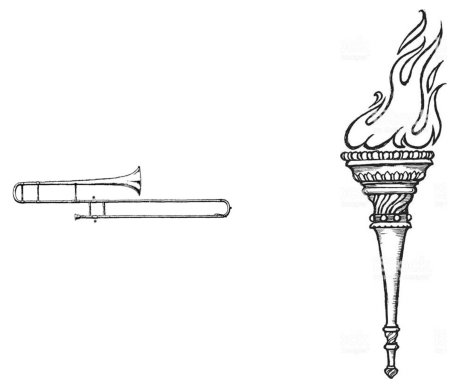

In [95]:
# check the images with extreme ratio
min1 = image_data[image_data['ratio']==min(image_data['ratio'])]
max1 = image_data[image_data['ratio']==max(image_data['ratio'])]
eximg1 = Image.open(traindata_dir+'/'+min1.iloc[0]['image_path'])
eximg2 = Image.open(traindata_dir+'/'+max1.iloc[0]['image_path'])

fig, ax = plt.subplots(1, 2)
ax[0].imshow(eximg1)
ax[0].axis('off')
ax[1].imshow(eximg2)
ax[1].axis('off')

- 위와 같이 가로-세로 비가 긴 이미지는 random crop 시 이미지 정보가 손상되기 때문에 별도의 대책이 필요함

Text(0.5, 1.0, 'mean blue value distribution')

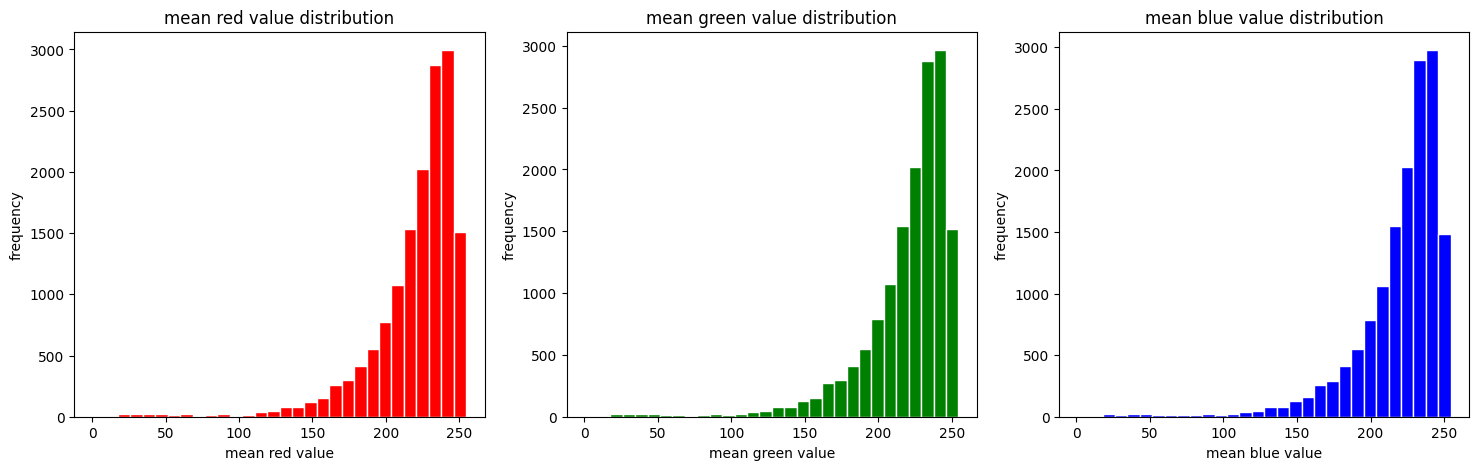

In [61]:
# check the RGB value
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# red channel
ax[0].hist(image_data['mean_red'], bins=30, color='red', ec='white')
ax[0].set_xlabel('mean red value')
ax[0].set_ylabel('frequency')
ax[0].set_title('mean red value distribution')

# green channel
ax[1].hist(image_data['mean_green'], bins=30, color='green', ec='white')
ax[1].set_xlabel('mean green value')
ax[1].set_ylabel('frequency')
ax[1].set_title('mean green value distribution')

# blue channel
ax[2].hist(image_data['mean_blue'], bins=30, color='blue', ec='white')
ax[2].set_xlabel('mean blue value')
ax[2].set_ylabel('frequency')
ax[2].set_title('mean blue value distribution')

- 특이 사항 보이지 않음. mean R, G, B value가 모두 높은 것은 대부분이 검은색 스케치선의 이미지이기 때문??

In [78]:
# check the images with specific colors
redratio = image_data['mean_red']/(image_data['mean_red']+image_data['mean_blue']+image_data['mean_green'])
blueratio = image_data['mean_blue']/(image_data['mean_red']+image_data['mean_blue']+image_data['mean_green'])
greenratio = image_data['mean_green']/(image_data['mean_red']+image_data['mean_blue']+image_data['mean_green'])

image_data['redratio'] = redratio
image_data['blueratio'] = blueratio
image_data['greenratio'] = greenratio

In [84]:
maxred = image_data[image_data['redratio']==max(image_data['redratio'])]
minred = image_data[image_data['redratio']==min(image_data['redratio'])]

maxgreen = image_data[image_data['greenratio']==max(image_data['greenratio'])]
mingreen = image_data[image_data['greenratio']==min(image_data['greenratio'])]

maxblue = image_data[image_data['blueratio']==max(image_data['blueratio'])]
minblue = image_data[image_data['blueratio']==min(image_data['blueratio'])]

In [85]:
maxredimg = Image.open(traindata_dir+'/'+maxred.iloc[0]['image_path'])
minredimg = Image.open(traindata_dir+'/'+minred.iloc[0]['image_path'])

maxgreenimg = Image.open(traindata_dir+'/'+maxgreen.iloc[0]['image_path'])
mingreenimg = Image.open(traindata_dir+'/'+mingreen.iloc[0]['image_path'])

maxblueimg = Image.open(traindata_dir+'/'+maxblue.iloc[0]['image_path'])
minblueimg = Image.open(traindata_dir+'/'+minblue.iloc[0]['image_path'])


Text(0.5, 0.98, 'Red chennel')

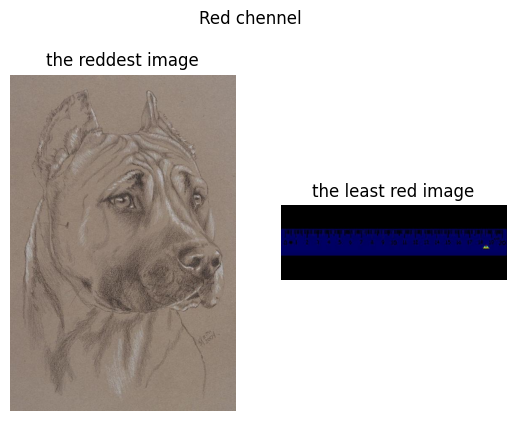

In [96]:
# red channel
fig, ax = plt.subplots(1, 2)

ax[0].imshow(maxredimg)
ax[0].set_title('the reddest image')
ax[0].axis('off')

ax[1].imshow(minredimg)
ax[1].set_title('the least red image')
ax[1].axis('off')

fig.suptitle('Red chennel')

Text(0.5, 0.98, 'Blue chennel')

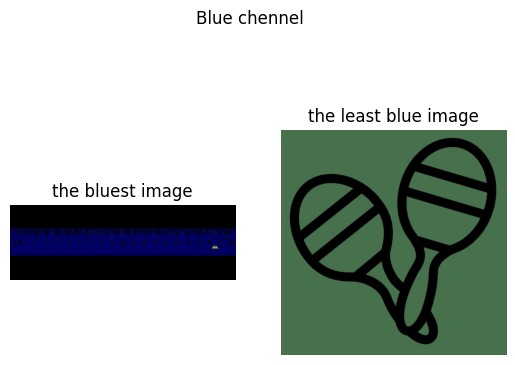

In [97]:
# blue channel
fig, ax = plt.subplots(1, 2)

ax[0].imshow(maxblueimg)
ax[0].set_title('the bluest image')
ax[0].axis('off')

ax[1].imshow(minblueimg)
ax[1].set_title('the least blue image')
ax[1].axis('off')

fig.suptitle('Blue chennel')

Text(0.5, 0.98, 'Green chennel')

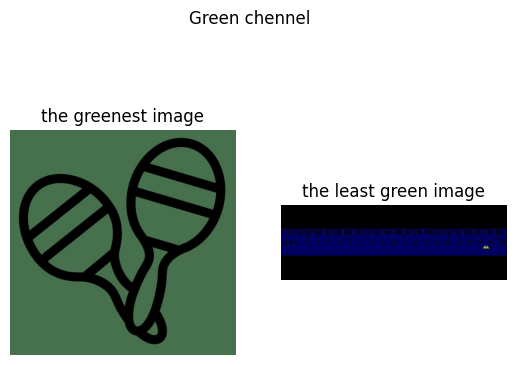

In [98]:
# green channel
fig, ax = plt.subplots(1, 2)

ax[0].imshow(maxgreenimg)
ax[0].set_title('the greenest image')
ax[0].axis('off')

ax[1].imshow(mingreenimg)
ax[1].set_title('the least green image')
ax[1].axis('off')

fig.suptitle('Green chennel')

- color 이미지도 보임 → greyscale로 변환 후 학습 필요?

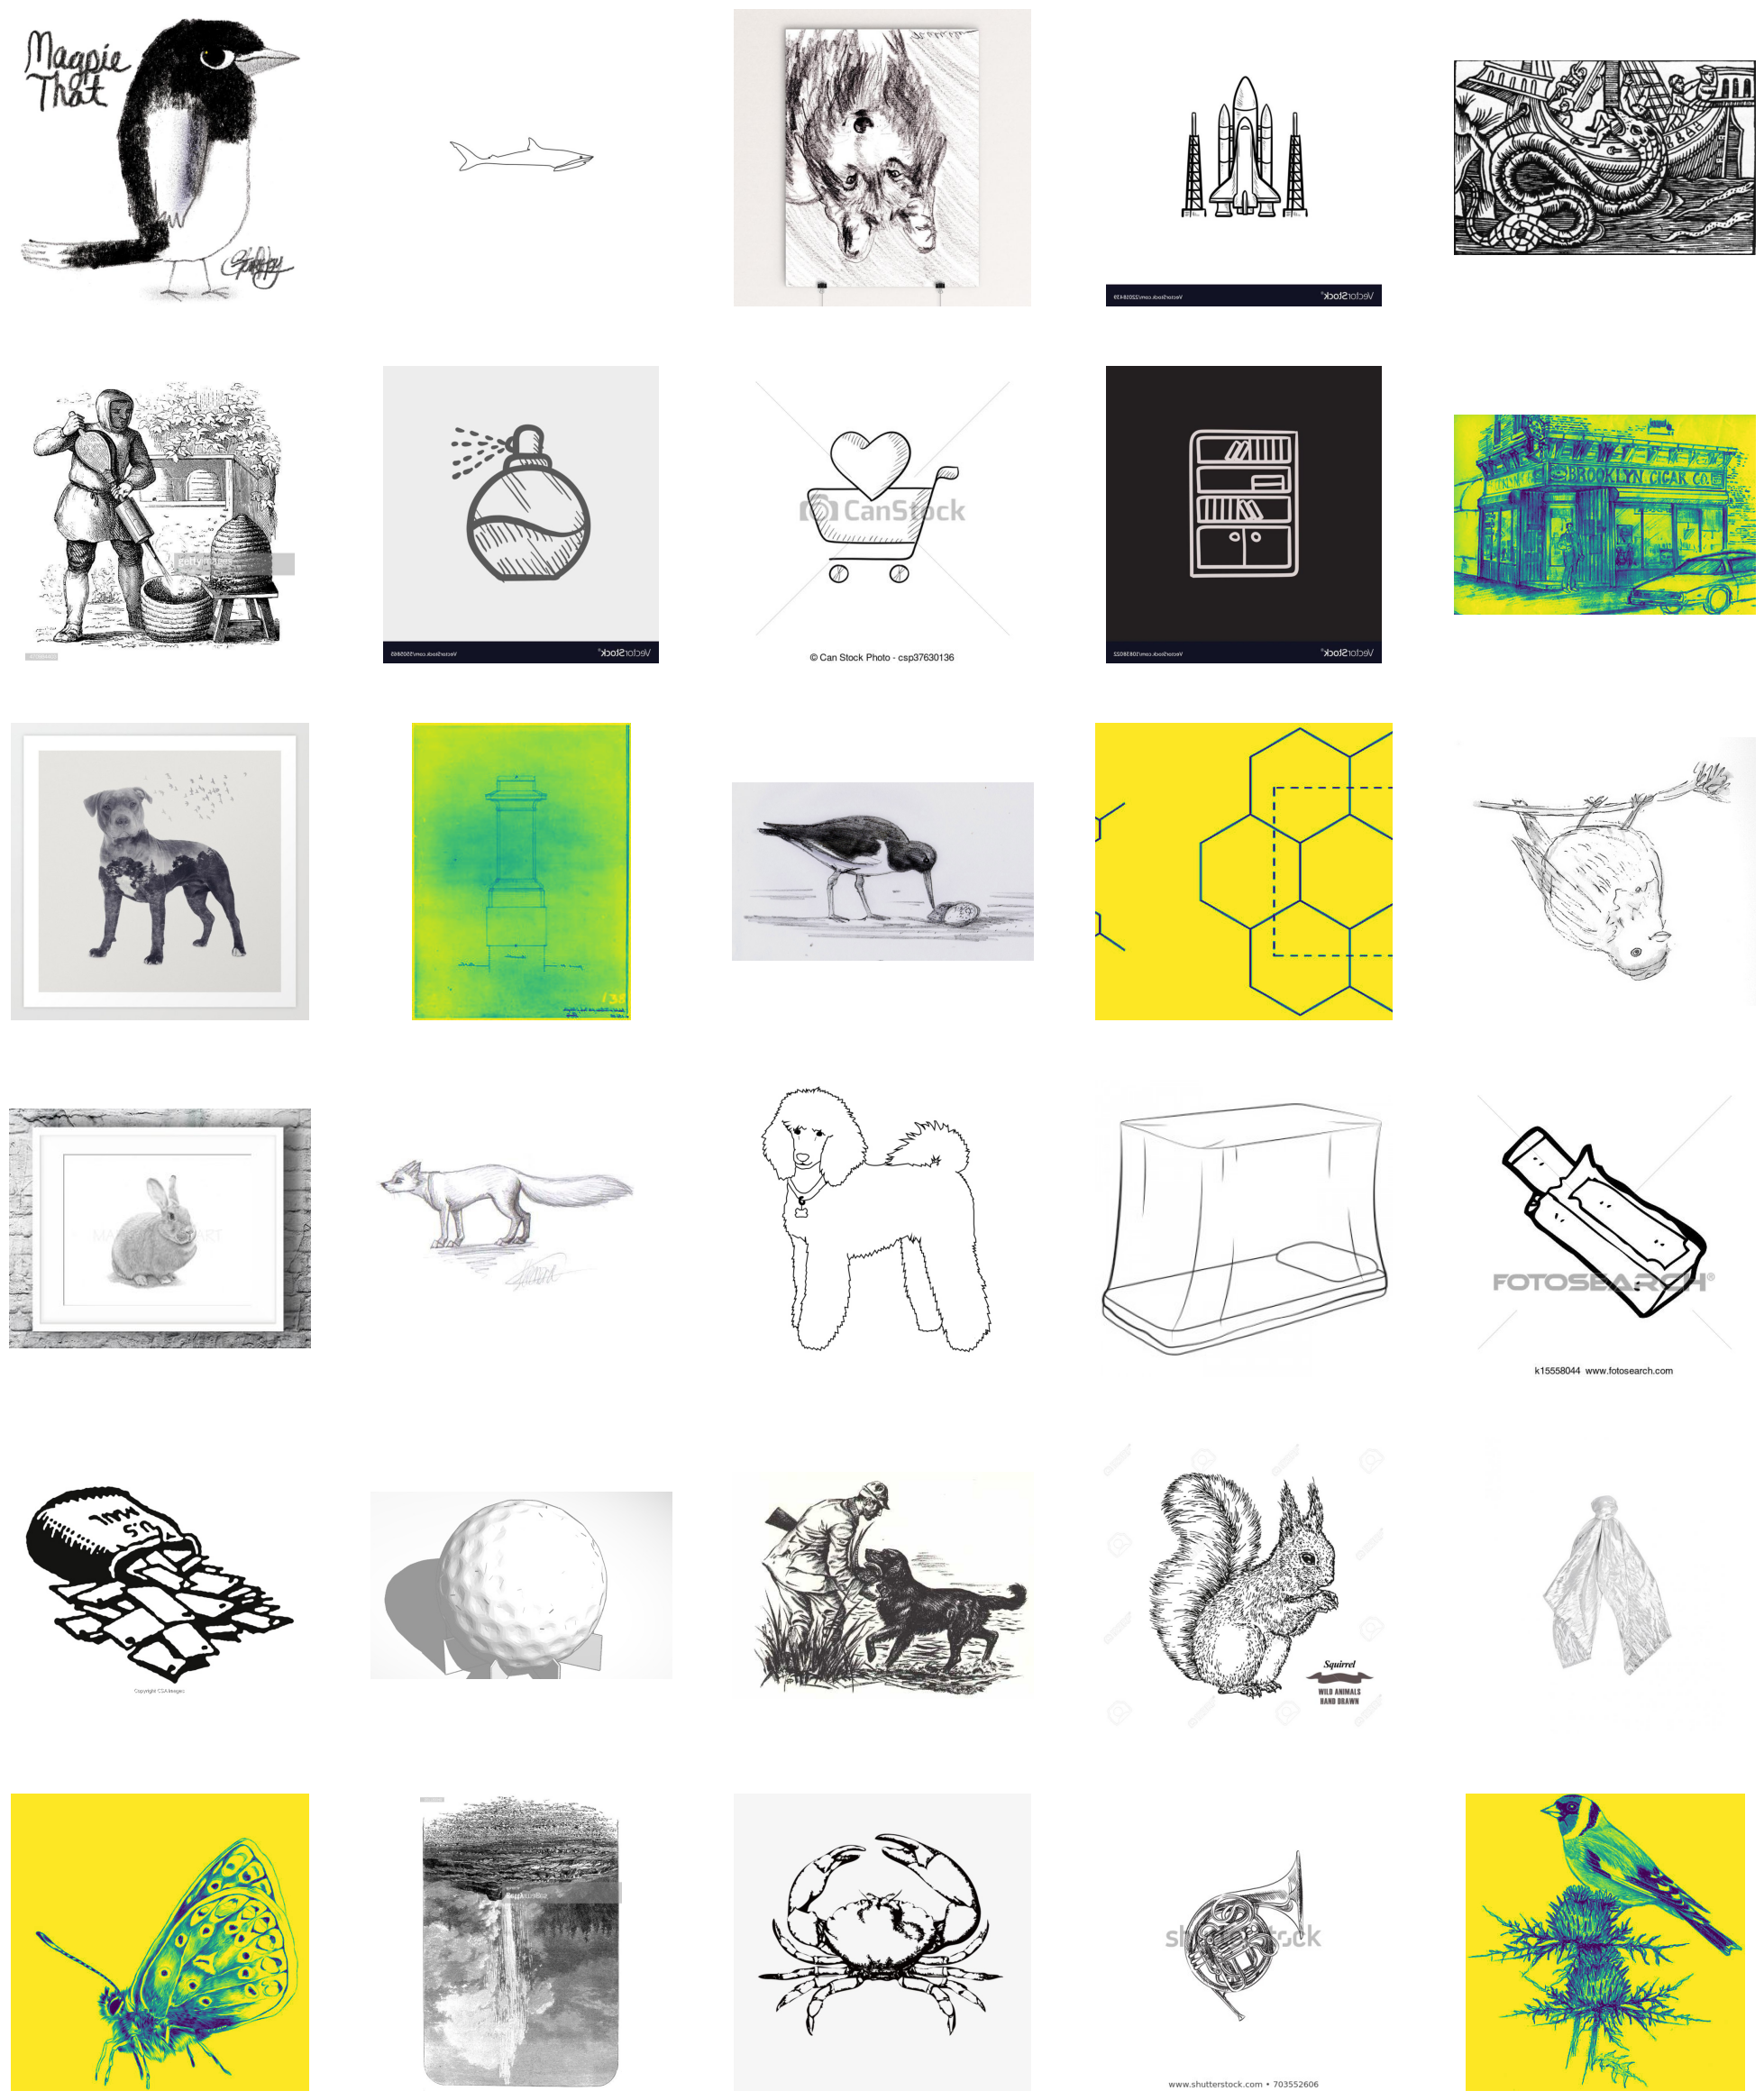

In [101]:
# Let's check the images with our own eyes
fig, ax = plt.subplots(6, 5, figsize=(25, 30))

for a in ax.reshape(-1):
    img_path = np.random.choice(train_images)
    img = Image.open(img_path)
    a.imshow(img)
    a.axis('off')
plt.show()

# repeating this block can show various images

- 워터마크, 손글씨, 저작권 표시 등 그림 인식에 방해되는 요소들이 보임 → 전처리 방법 모색이 필요!
- 화가가 그린 듯한 정교한 그림부터 어린이가 그린 투박한 그림까지 퀄리티가 다양함
- 채색된 이미지도 다수 존재 → greyscale로 변환
- 분류하고자 하는 대상 외에도 풍경화처럼 보이거나 다른 대상들이 섞여 있는 그림들이 보임
- 대상이 여러 개 포함된 이미지도 있음
- crop, flip 된 이미지들도 있음